## Finding Magnetic Nulls near a reconnection event observed by MMS

This notebook will show how to use PySPEDAS to locate and characterize magnetic null points.

During a dayside magneopause crossing on 2023-03-24, MMS observed the signature of a reconnection event: the magnetic field direction reversed (so, nearly antiparallel field lines in close proximity), simultaneous with fast (~400 km/sec) particle flows that also reversed direction during the event.

Magnetic null points are an important aspect of the reconnection process.  Since MMS has four probes taking simultaneous magnetic field measurements in a tight, approximately tetrahedral formation, we have enough information to model the magnetic field in 3 dimensions in the vicinity of the MMS constellation.

The method here is known as the First Order Taylor Expansion (FOTE) method.   By using the MMS field measurements, we can estimate the B field vector at the center of the tetrahedron. We can also estimate the 3x3 Jacobian matrix, capturing the partial derivative of the vector components Bx, By, and Bz with respect to the local X, Y, and Z coordinates.   

Together, these two estimates can be used to solve for a location where Bx = By = Bz: that is, a magnetic null point.   As long as the field measurements aren't identical between probes, a null can be found.  Whether that finding is credible or not depends on how well the assumption of linear field gradients holds over the distence to the null, and on some other figures of merit that can be derived from the trace and eigenvalues of the Jacobean matrix.

We'll start by importing some pyspedas and pytplot tools.

In [ ]:
import os
os.environ["SPEDAS_DATA_DIR"] = "/home/jovyan/scratch_space/pyspedas_data"


In [1]:
# Here are some imports we'll need below.
import pyspedas
import pytplot

# We'll import a few pytplot routines, to simplify things below
from pytplot import timespan, highlight, time_double, options, tplot, tnames


09-May-24 15:48:07: /Users/jwl/PycharmProjects/summer-school-24/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



We need to know the MMS spacecraft locations, so we'll get them with mms_load_state()

In [2]:
state_vars = pyspedas.mms.mms_load_state(trange=['2023-03-24/07:00','2023-03-24/08:00'],probe=['1','2','3','4'])

# For FGM, we'll use the survey data for the overview plot, and burst data for the
# null analysis.

fgm_vars = pyspedas.mms.fgm(trange=['2023-03-24/07:00','2023-03-24/08:00'],probe=['1','2','3','4'],data_rate='brst',time_clip=True)
fgm_vars = pyspedas.mms.fgm(trange=['2023-03-24/07:00','2023-03-24/08:00'],probe=['1'],data_rate='srvy',time_clip=True)

fpi_vars = pyspedas.mms.mms_load_fpi(trange=['2023-03-24/07:00','2023-03-24/08:00'],probe=['1','2','3','4'],time_clip=True,data_rate='fast')

# Reset time limits from previous examples
timespan('2023-03-24/07:00',60.0,'minutes')

pytplot.tplot_names()

09-May-24 15:48:10: Loading pydata/ancillary/mms1/defeph/MMS1_DEFEPH_2023082_2023083.V01
09-May-24 15:48:10: Loading pydata/ancillary/mms1/defeph/MMS1_DEFEPH_2023083_2023084.V01
09-May-24 15:48:10: Loading pydata/ancillary/mms2/defeph/MMS2_DEFEPH_2023082_2023083.V01
09-May-24 15:48:10: Loading pydata/ancillary/mms2/defeph/MMS2_DEFEPH_2023083_2023084.V01
09-May-24 15:48:11: Loading pydata/ancillary/mms3/defeph/MMS3_DEFEPH_2023082_2023083.V01
09-May-24 15:48:11: Loading pydata/ancillary/mms3/defeph/MMS3_DEFEPH_2023083_2023084.V01
09-May-24 15:48:11: Loading pydata/ancillary/mms4/defeph/MMS4_DEFEPH_2023082_2023083.V01
09-May-24 15:48:12: Loading pydata/ancillary/mms4/defeph/MMS4_DEFEPH_2023083_2023084.V01
09-May-24 15:48:14: Loading pydata/mms1/fgm/brst/l2/2023/03/24/mms1_fgm_brst_l2_20230324065643_v5.391.0.cdf
09-May-24 15:48:14: Loading pydata/mms1/fgm/brst/l2/2023/03/24/mms1_fgm_brst_l2_20230324070053_v5.391.0.cdf
09-May-24 15:48:14: Loading pydata/mms1/fgm/brst/l2/2023/03/24/mms1_fgm_

0 : mms1_defeph_pos
1 : mms1_defeph_vel
2 : mms2_defeph_pos
3 : mms2_defeph_vel
4 : mms3_defeph_pos
5 : mms3_defeph_vel
6 : mms4_defeph_pos
7 : mms4_defeph_vel
8 : Epoch
9 : mms1_fgm_b_gse_brst_l2
10 : mms1_fgm_b_gsm_brst_l2
11 : mms1_fgm_b_dmpa_brst_l2
12 : mms1_fgm_b_bcs_brst_l2
13 : mms1_fgm_flag_brst_l2
14 : Epoch_state
15 : mms1_fgm_hirange_brst_l2
16 : mms1_fgm_bdeltahalf_brst_l2
17 : mms1_fgm_stemp_brst_l2
18 : mms1_fgm_etemp_brst_l2
19 : mms1_fgm_mode_brst_l2
20 : mms2_fgm_b_gse_brst_l2
21 : mms2_fgm_b_gsm_brst_l2
22 : mms2_fgm_b_dmpa_brst_l2
23 : mms2_fgm_b_bcs_brst_l2
24 : mms2_fgm_flag_brst_l2
25 : mms2_fgm_hirange_brst_l2
26 : mms2_fgm_bdeltahalf_brst_l2
27 : mms2_fgm_stemp_brst_l2
28 : mms2_fgm_etemp_brst_l2
29 : mms2_fgm_mode_brst_l2
30 : mms3_fgm_b_gse_brst_l2
31 : mms3_fgm_b_gsm_brst_l2
32 : mms3_fgm_b_dmpa_brst_l2
33 : mms3_fgm_b_bcs_brst_l2
34 : mms3_fgm_flag_brst_l2
35 : mms3_fgm_hirange_brst_l2
36 : mms3_fgm_bdeltahalf_brst_l2
37 : mms3_fgm_stemp_brst_l2
38 : mms3_f

['mms1_defeph_pos',
 'mms1_defeph_vel',
 'mms2_defeph_pos',
 'mms2_defeph_vel',
 'mms3_defeph_pos',
 'mms3_defeph_vel',
 'mms4_defeph_pos',
 'mms4_defeph_vel',
 'Epoch',
 'mms1_fgm_b_gse_brst_l2',
 'mms1_fgm_b_gsm_brst_l2',
 'mms1_fgm_b_dmpa_brst_l2',
 'mms1_fgm_b_bcs_brst_l2',
 'mms1_fgm_flag_brst_l2',
 'Epoch_state',
 'mms1_fgm_hirange_brst_l2',
 'mms1_fgm_bdeltahalf_brst_l2',
 'mms1_fgm_stemp_brst_l2',
 'mms1_fgm_etemp_brst_l2',
 'mms1_fgm_mode_brst_l2',
 'mms2_fgm_b_gse_brst_l2',
 'mms2_fgm_b_gsm_brst_l2',
 'mms2_fgm_b_dmpa_brst_l2',
 'mms2_fgm_b_bcs_brst_l2',
 'mms2_fgm_flag_brst_l2',
 'mms2_fgm_hirange_brst_l2',
 'mms2_fgm_bdeltahalf_brst_l2',
 'mms2_fgm_stemp_brst_l2',
 'mms2_fgm_etemp_brst_l2',
 'mms2_fgm_mode_brst_l2',
 'mms3_fgm_b_gse_brst_l2',
 'mms3_fgm_b_gsm_brst_l2',
 'mms3_fgm_b_dmpa_brst_l2',
 'mms3_fgm_b_bcs_brst_l2',
 'mms3_fgm_flag_brst_l2',
 'mms3_fgm_hirange_brst_l2',
 'mms3_fgm_bdeltahalf_brst_l2',
 'mms3_fgm_stemp_brst_l2',
 'mms3_fgm_etemp_brst_l2',
 'mms3_fgm_m

The MMS ephemeris data is in ECI coordinates.  We'll be working in GSE, so we need to transform the loaded variables.

In [24]:
# To use the MMS qcotrans routine, the quaternions representing the transforms must be
# loaded from the MEC dataset.
pyspedas.mms.mec(trange=['2023-03-24/07:00','2023-03-24/08:00'], probe=['1','2','3','4'])

for i in ('1','2','3','4'): 
    pyspedas.mms.mms_qcotrans('mms'+i+'_defeph_pos','mms'+i+'_defeph_pos_gse',in_coord='eci',out_coord='gse')
    pyspedas.mms.mms_qcotrans('mms'+i+'_defeph_vel','mms'+i+'_defeph_vel_gse',in_coord='eci',out_coord='gse')


10-May-24 16:27:06: Loading pydata/mms1/mec/srvy/l2/epht89q/2023/03/mms1_mec_srvy_l2_epht89q_20230324_v2.2.0.cdf
10-May-24 16:27:06: Loading pydata/mms2/mec/srvy/l2/epht89q/2023/03/mms2_mec_srvy_l2_epht89q_20230324_v2.2.0.cdf
10-May-24 16:27:06: Loading pydata/mms3/mec/srvy/l2/epht89q/2023/03/mms3_mec_srvy_l2_epht89q_20230324_v2.2.0.cdf
10-May-24 16:27:07: Loading pydata/mms4/mec/srvy/l2/epht89q/2023/03/mms4_mec_srvy_l2_epht89q_20230324_v2.2.0.cdf
10-May-24 16:27:07: Interpolating the data to the MEC quaternion time stamps.
10-May-24 16:27:07: tinterpol (linear) was applied to: mms1_defeph_pos-itrp
10-May-24 16:27:07: Interpolating the data to the MEC quaternion time stamps.
10-May-24 16:27:07: tinterpol (linear) was applied to: mms1_defeph_vel-itrp
10-May-24 16:27:08: Interpolating the data to the MEC quaternion time stamps.
10-May-24 16:27:08: tinterpol (linear) was applied to: mms2_defeph_pos-itrp
10-May-24 16:27:08: Interpolating the data to the MEC quaternion time stamps.
10-May-2

We'll generate a summary plot of the data loaded so far:

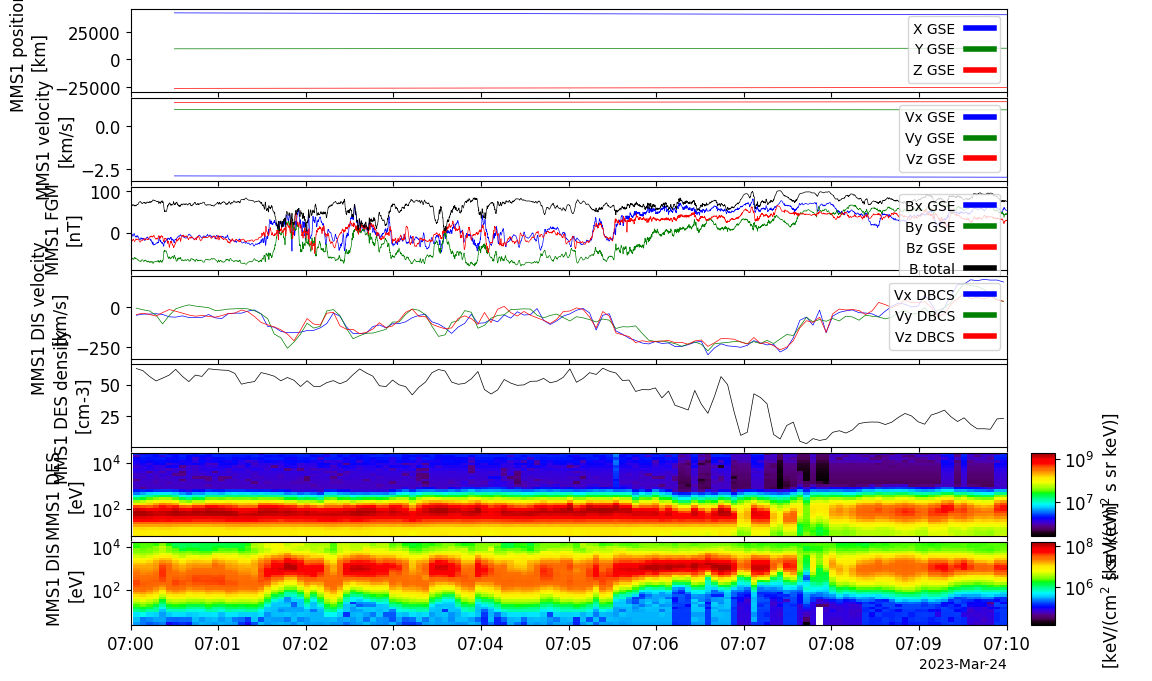

In [27]:

timespan('2023-03-24/07:00',10,'minutes')
options('mms1_des_numberdensity_fast','ylog',False)
fig1_vars=['mms1_defeph_pos_gse','mms1_defeph_vel_gse','mms1_fgm_b_gse_srvy_l2','mms1_dis_bulkv_dbcs_fast','mms1_des_numberdensity_fast','mms1_des_energyspectr_omni_fast','mms1_dis_energyspectr_omni_fast']

tplot(fig1_vars)

Let's get a sense of the probe separations and orbital velocity during this time:

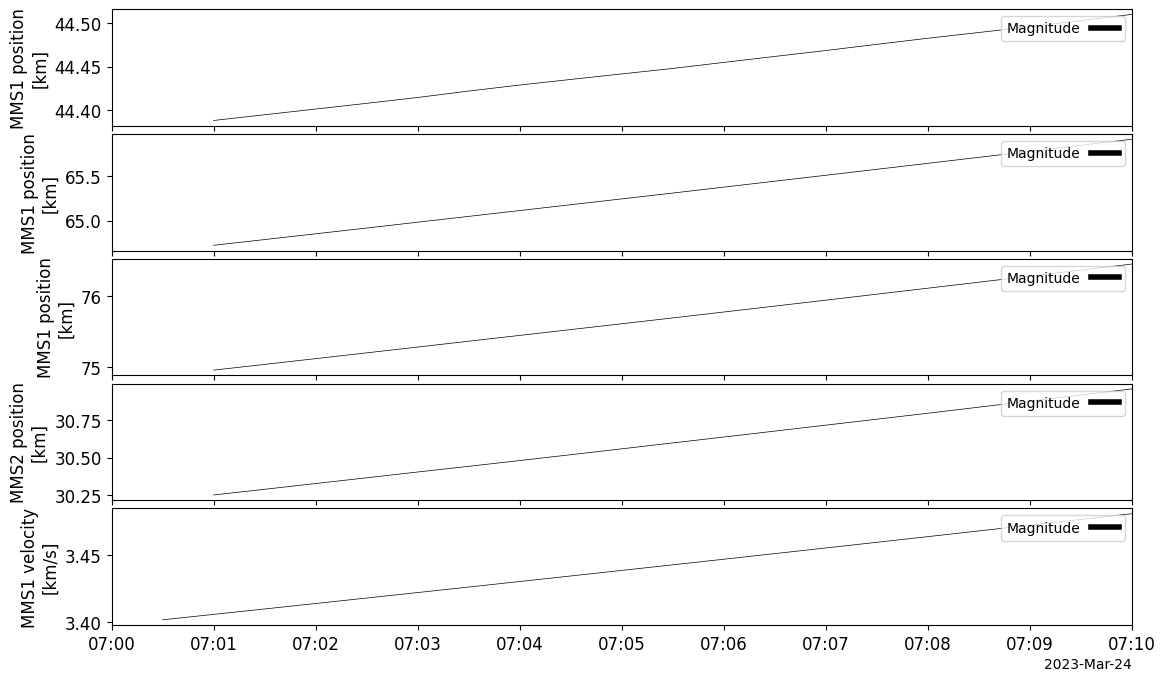

In [39]:
from pytplot import subtract
from pyspedas import tvectot

subtract('mms1_defeph_pos_gse','mms2_defeph_pos_gse',newname='mms1_mms2_dist')
subtract('mms1_defeph_pos_gse','mms3_defeph_pos_gse',newname='mms1_mms3_dist')
subtract('mms1_defeph_pos_gse','mms4_defeph_pos_gse',newname='mms1_mms4_dist')
subtract('mms2_defeph_pos_gse','mms3_defeph_pos_gse',newname='mms2_mms3_dist')
tvectot(['mms1_mms2_dist','mms1_mms3_dist','mms1_mms4_dist','mms2_mms3_dist','mms1_defeph_vel_gse'])
tplot(['mms1_mms2_dist_tot','mms1_mms3_dist_tot','mms1_mms4_dist_tot', 'mms2_mms3_dist_tot','mms1_defeph_vel_gse_tot'])



So for future reference, the tetrahedron size is on the order of 75 km, and the constellation is moving at about 3.45 km/sec.

Now we will find the magnetic nulls during this event, and examine the field toplology for a couple of them:

In [22]:
mms_positions = ['mms1_defeph_pos_gse','mms2_defeph_pos_gse','mms3_defeph_pos_gse','mms4_defeph_pos_gse']
mms_fields = ['mms1_fgm_b_gse_brst_l2','mms2_fgm_b_gse_brst_l2','mms3_fgm_b_gse_brst_l2','mms4_fgm_b_gse_brst_l2']

null_vars = pyspedas.find_magnetic_nulls_fote(fields=mms_fields, positions=mms_positions, smooth_fields=True)

pytplot.tplot_names()

print(null_vars)


10-May-24 16:23:55: tsmooth was applied to: mms1_fgm_b_gse_brst_l2_sm
10-May-24 16:23:57: tsmooth was applied to: mms2_fgm_b_gse_brst_l2_sm
10-May-24 16:23:59: tsmooth was applied to: mms3_fgm_b_gse_brst_l2_sm
10-May-24 16:24:00: tsmooth was applied to: mms4_fgm_b_gse_brst_l2_sm
10-May-24 16:24:00: tinterpol (linear) was applied to: pos1_i
10-May-24 16:24:00: tinterpol (linear) was applied to: pos2_i
10-May-24 16:24:00: tinterpol (linear) was applied to: pos3_i
10-May-24 16:24:00: tinterpol (linear) was applied to: pos4_i
10-May-24 16:24:00: tinterpol (linear) was applied to: b1_i
10-May-24 16:24:01: tinterpol (linear) was applied to: b2_i
10-May-24 16:24:01: tinterpol (linear) was applied to: b3_i
10-May-24 16:24:01: tinterpol (linear) was applied to: b4_i
10-May-24 16:24:09: Calculations completed


0 : mms1_defeph_pos
1 : mms1_defeph_vel
2 : mms2_defeph_pos
3 : mms2_defeph_vel
4 : mms3_defeph_pos
5 : mms3_defeph_vel
6 : mms4_defeph_pos
7 : mms4_defeph_vel
8 : Epoch
9 : mms1_fgm_b_gse_brst_l2
10 : mms1_fgm_b_gsm_brst_l2
11 : mms1_fgm_b_dmpa_brst_l2
12 : mms1_fgm_b_bcs_brst_l2
13 : mms1_fgm_flag_brst_l2
14 : Epoch_state
15 : mms1_fgm_hirange_brst_l2
16 : mms1_fgm_bdeltahalf_brst_l2
17 : mms1_fgm_stemp_brst_l2
18 : mms1_fgm_etemp_brst_l2
19 : mms1_fgm_mode_brst_l2
20 : mms2_fgm_b_gse_brst_l2
21 : mms2_fgm_b_gsm_brst_l2
22 : mms2_fgm_b_dmpa_brst_l2
23 : mms2_fgm_b_bcs_brst_l2
24 : mms2_fgm_flag_brst_l2
25 : mms2_fgm_hirange_brst_l2
26 : mms2_fgm_bdeltahalf_brst_l2
27 : mms2_fgm_stemp_brst_l2
28 : mms2_fgm_etemp_brst_l2
29 : mms2_fgm_mode_brst_l2
30 : mms3_fgm_b_gse_brst_l2
31 : mms3_fgm_b_gsm_brst_l2
32 : mms3_fgm_b_dmpa_brst_l2
33 : mms3_fgm_b_bcs_brst_l2
34 : mms3_fgm_flag_brst_l2
35 : mms3_fgm_hirange_brst_l2
36 : mms3_fgm_bdeltahalf_brst_l2
37 : mms3_fgm_stemp_brst_l2
38 : mms3_f

The variables returned by find_magnetic_nulls_fote are:

null_pos: The position of reported null points, in the same coordinate system as the position inputs (here, GSE)

null_bary_dist:  The scalar distance between the null and the consteallation barycenter

null_bary_dist_types:  A composite tplot variable with a scatter plot of null topology types, superimposed on the null_bary_dist values

null_sc_distances: The scalar distances between the null point and each of the four spacecraft.

null_fom:  Two scalar figures of merit, eta and xi, representing the confidence in the null detection and null topology classification

null_typecode: Integer type codes representing the topological classification of the null points.

max_reconstruction_error:  The maximum difference, in nT, between the spacecraft magnetic field measurements, and the Taylor expansion of the field using the calculated field value and field gradients at the constellation barycenter.

It's hard to make sense of the plots of magnetic null results on timescales longer than a few seconds, so we'll want to zoom in on some shorter time intervals.,

First, we'll look at 60 seconds worth of data starting at 07:01:


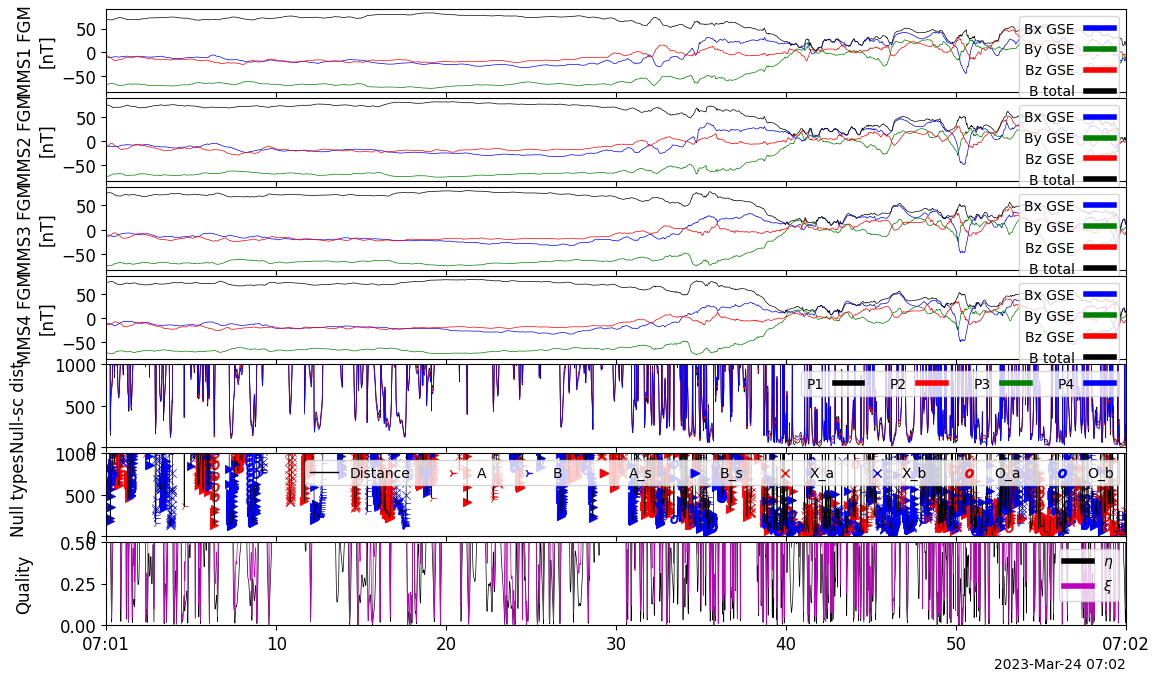

In [14]:
timespan('2023-03-24/07:01:00',60,'seconds')
options('null_fom','yrange',[0.0,0.5])
tplot(['mms1_fgm_b_gse_brst_l2','mms2_fgm_b_gse_brst_l2','mms3_fgm_b_gse_brst_l2','mms4_fgm_b_gse_brst_l2','null_sc_distances','null_bary_dist_types','null_fom'])

Just after 07:01:40, all four spacecraft are seeing low fields, so let's zoom in on that:

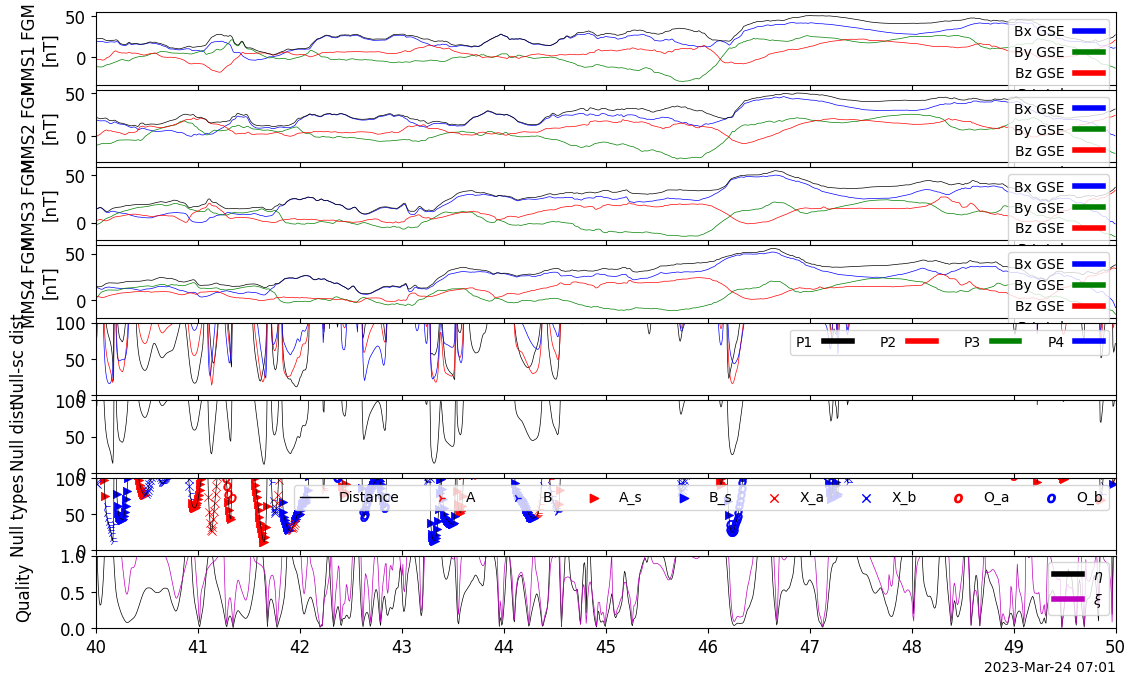

In [40]:
timespan('2023-03-24/07:01:40',10,'seconds')
options('null_fom','yrange',[0.0,1.0])
options('null_sc_distances','yrange',[0.0, 100.0])
options('null_bary_dist','yrange',[0.0,100.0])
tplot(['mms1_fgm_b_gse_brst_l2','mms2_fgm_b_gse_brst_l2','mms3_fgm_b_gse_brst_l2','mms4_fgm_b_gse_brst_l2','null_sc_distances','null_bary_dist','null_bary_dist_types','null_fom'])

Looking at the quality variables (lower=better), and null_sc and null_barycenter distances, it appears that several magnetic nulls were reliably detected and classified, perhaps even enclosed by the MMS tetrahedron, around 41-42 and 46 seconds after 07:01 UT.   


Now we'll look at another time interval starting at 07:07:00:

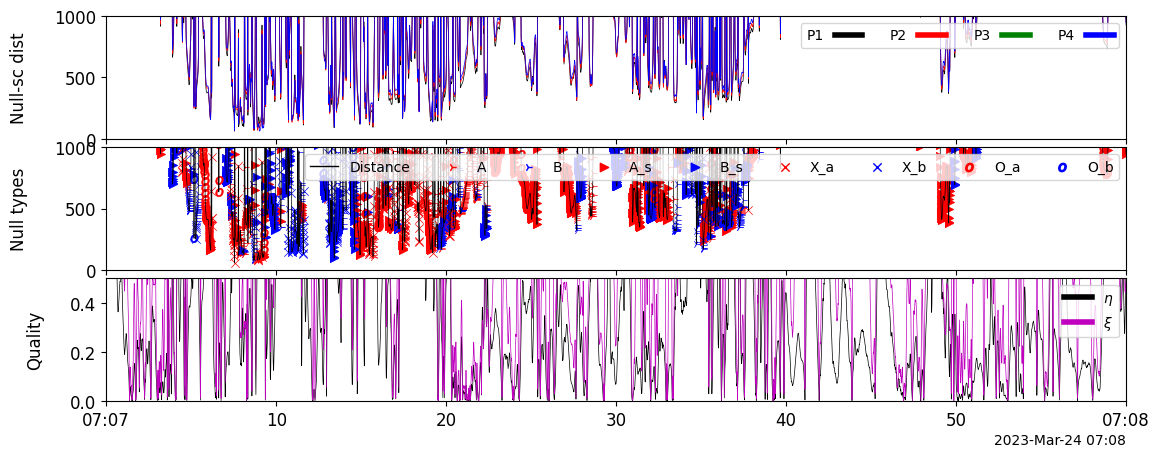

In [46]:
timespan('2023-03-24/07:07:00',60,'seconds')
options('null_fom','yrange',[0.0,0.5])
options('null_sc_distances','yrange',[0.0, 1000.0])
options('null_bary_dist','yrange',[0.0,1000.0])
tplot(['null_sc_distances','null_bary_dist_types','null_fom'])

Now we'll look at the time interval 07:07:20 - 07:07:25:

10-May-24 17:07:07: No data found in the time range: null_type8


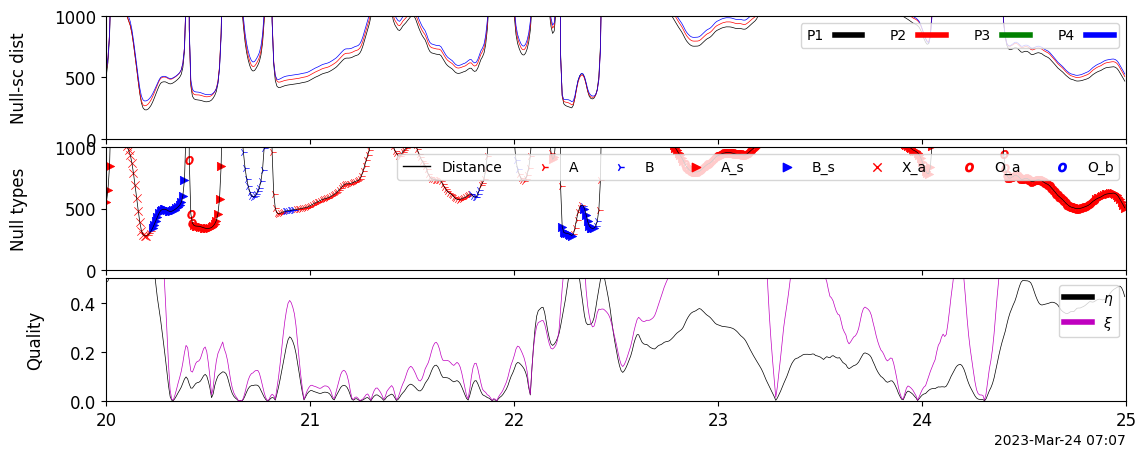

In [47]:
timespan('2023-03-24/07:07:20',5,'seconds')
tplot(['null_sc_distances','null_bary_dist_types','null_fom'])

Between 21-15 seconds after 7:07, we seem to have a reliable detection of a Type A radial null at a distance of about 500 km from the formation.  This coincides with the magnetic reconnection signature observed in MMS-1 at this time: anti-parallel magnetic field lines, fast ion flows and flow reversals.